## Setup and Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

## Define the Pairs Trading Strategy Class

In [81]:
class PairsTradingStrategy:
    """
    A comprehensive pairs trading strategy implementation for any pair of stocks.
    """
    
    def __init__(self, ticker1='KO', ticker2='PEP', start_date='2019-01-01', end_date='2024-01-01'):
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.spread = None
        self.signals = None
        self.results = {}
        
    def fetch_data(self):
        """Fetch historical price data for both tickers."""
        print(f"Fetching data for {self.ticker1} and {self.ticker2}...")
        
        # Download data
        data = yf.download([self.ticker1, self.ticker2], 
                          start=self.start_date, 
                          end=self.end_date, 
                          progress=False)
        
        # Debug: Let's see what we're working with
        print(f"Data shape: {data.shape}")
        print(f"Column names: {data.columns.tolist()}")
        
        # Handle different yfinance output formats
        if isinstance(data.columns, pd.MultiIndex):
            # Multi-level columns case
            # Get available price types
            available_prices = data.columns.get_level_values(0).unique().tolist()
            print(f"Available price types: {available_prices}")
            
            # Try different column names that yfinance might use
            price_column = None
            for col_name in ['Adj Close', 'Adj_Close', 'AdjClose', 'adjclose', 'Close']:
                if col_name in available_prices:
                    price_column = col_name
                    break
            
            if price_column is None:
                # If no adjusted close, use regular close
                if 'Close' in available_prices:
                    price_column = 'Close'
                    print("Warning: Using 'Close' instead of 'Adj Close'")
                else:
                    raise ValueError(f"Could not find price data. Available columns: {available_prices}")
            
            # Extract the price data
            self.data = data[price_column].copy()
            
        else:
            # Single-level columns case
            col_names = data.columns.tolist()
            
            # Try to find the appropriate column
            price_column = None
            for col_name in ['Adj Close', 'Adj_Close', 'AdjClose', 'adjclose', 'Close']:
                if col_name in col_names:
                    price_column = col_name
                    break
            
            if price_column is None:
                raise ValueError(f"Could not find price data. Available columns: {col_names}")
            
            self.data = data[[price_column]].copy()
        
        # Ensure we have data for both tickers
        if self.data.shape[1] != 2:
            # Try downloading separately if combined download failed
            print("Combined download may have failed. Trying separate downloads...")
            
            ticker1_data = yf.download(self.ticker1, 
                                     start=self.start_date, 
                                     end=self.end_date, 
                                     progress=False)
            ticker2_data = yf.download(self.ticker2, 
                                     start=self.start_date, 
                                     end=self.end_date, 
                                     progress=False)
            
            # Find the price column for each ticker
            price_col1 = None
            price_col2 = None
            
            for col_name in ['Adj Close', 'Adj_Close', 'AdjClose', 'Close']:
                if col_name in ticker1_data.columns:
                    price_col1 = col_name
                if col_name in ticker2_data.columns:
                    price_col2 = col_name
                if price_col1 and price_col2:
                    break
            
            if not price_col1 or not price_col2:
                raise ValueError("Could not find price data in individual ticker downloads")
            
            # Combine the data
            self.data = pd.DataFrame({
                self.ticker1: ticker1_data[price_col1],
                self.ticker2: ticker2_data[price_col2]
            })
        else:
            # Rename columns to ticker symbols
            self.data.columns = [self.ticker1, self.ticker2]
        
        # Drop any NaN values
        self.data = self.data.dropna()
        
        print(f"Successfully loaded data with shape: {self.data.shape}")
        
        return self.data
    
    def test_stationarity(self, series, name):
        """Test if a time series is stationary using Augmented Dickey-Fuller test."""
        result = adfuller(series.dropna())
        print(f'\nADF Test for {name}:')
        print(f'ADF Statistic: {result[0]:.4f}')
        print(f'p-value: {result[1]:.4f}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value:.3f}')
        
        if result[1] <= 0.05:
            print(f"=> {name} is stationary (reject H0)")
        else:
            print(f"=> {name} is non-stationary (fail to reject H0)")
        return result[1] <= 0.05
    
    def test_cointegration(self):
        """Test for cointegration between the two time series."""
        # Test individual series for stationarity
        self.test_stationarity(self.data[self.ticker1], self.ticker1)
        self.test_stationarity(self.data[self.ticker2], self.ticker2)
        
        # Engle-Granger cointegration test
        score, pvalue, crit_values = coint(self.data[self.ticker1], self.data[self.ticker2])
        print(f'\n=== Cointegration Test Results ===')
        print(f'Test Statistic: {score:.4f}')
        print(f'p-value: {pvalue:.4f}')
        print(f'Critical Values: 1%: {crit_values[0]:.3f}, 5%: {crit_values[1]:.3f}, 10%: {crit_values[2]:.3f}')
        
        if pvalue < 0.05:
            print("=> Series are cointegrated (good for pairs trading)")
        else:
            print("=> Series are NOT cointegrated (caution advised)")
        
        return pvalue < 0.05, pvalue
    
    def calculate_hedge_ratio(self, method='ols'):
        """Calculate the hedge ratio between the two assets."""
        if method == 'ols':
            # OLS regression
            X = self.data[self.ticker2].values.reshape(-1, 1)
            y = self.data[self.ticker1].values
            model = LinearRegression()
            model.fit(X, y)
            hedge_ratio = model.coef_[0]
            intercept = model.intercept_
            print(f"\nHedge Ratio (OLS): {hedge_ratio:.4f}")
            print(f"Intercept: {intercept:.4f}")
        else:
            # Simple ratio
            hedge_ratio = self.data[self.ticker1].mean() / self.data[self.ticker2].mean()
            print(f"\nHedge Ratio (Simple): {hedge_ratio:.4f}")
        
        return hedge_ratio
    
    def calculate_spread(self, hedge_ratio=1.0):
        """Calculate the spread between the two assets."""
        self.spread = self.data[self.ticker1] - hedge_ratio * self.data[self.ticker2]
        
        # Test if spread is stationary
        print("\nTesting spread stationarity:")
        self.test_stationarity(self.spread, "Spread")
        
        return self.spread
    
    def calculate_zscore(self, window=60):
        """Calculate rolling z-score of the spread."""
        rolling_mean = self.spread.rolling(window=window).mean()
        rolling_std = self.spread.rolling(window=window).std()
        self.zscore = (self.spread - rolling_mean) / rolling_std
        return self.zscore
    
    def generate_signals(self, entry_threshold=1.0, exit_threshold=0.0):
        """Generate trading signals based on z-score thresholds."""
        self.signals = pd.DataFrame(index=self.data.index)
        self.signals['zscore'] = self.zscore
        self.signals['position'] = 0
        
        # Entry signals
        self.signals.loc[self.zscore > entry_threshold, 'position'] = -1  # Short spread
        self.signals.loc[self.zscore < -entry_threshold, 'position'] = 1  # Long spread
        
        # Exit signals (when z-score crosses zero)
        self.signals.loc[abs(self.zscore) < exit_threshold, 'position'] = 0
        
        # Forward fill positions
        self.signals['position'] = self.signals['position'].replace(0, np.nan).ffill().fillna(0)
        
        # Calculate position changes
        self.signals['trades'] = self.signals['position'].diff().fillna(0)
        
        return self.signals
    
    def backtest_strategy(self, transaction_cost=0.001):
        """Backtest the pairs trading strategy."""
        # Calculate daily returns
        returns = self.data.pct_change()
        
        # Strategy returns (with transaction costs)
        self.signals['strategy_returns'] = (
            self.signals['position'].shift(1) * 
            (returns[self.ticker1] - returns[self.ticker2])
        )
        
        # Apply transaction costs
        self.signals['tc_cost'] = abs(self.signals['trades']) * transaction_cost
        self.signals['strategy_returns_tc'] = (
            self.signals['strategy_returns'] - self.signals['tc_cost']
        )
        
        # Calculate cumulative returns
        self.signals['cumulative_returns'] = (
            (1 + self.signals['strategy_returns']).cumprod()
        )
        self.signals['cumulative_returns_tc'] = (
            (1 + self.signals['strategy_returns_tc']).cumprod()
        )
        
        # Benchmark (buy and hold both stocks equally)
        benchmark_returns = 0.5 * returns[self.ticker1] + 0.5 * returns[self.ticker2]
        self.signals['benchmark_cumulative'] = (1 + benchmark_returns).cumprod()
        
        return self.signals
    
    def calculate_performance_metrics(self, risk_free_rate=0.045):
        """Calculate various performance metrics."""
        # Annualized metrics
        returns = self.signals['strategy_returns_tc'].dropna()
        
        # Total return
        total_return = self.signals['cumulative_returns_tc'].iloc[-1] - 1
        
        # Annualized return (CAGR)
        n_days = len(returns)
        n_years = n_days / 252
        cagr = (1 + total_return) ** (1/n_years) - 1
        
        # Sharpe ratio
        rf_daily = risk_free_rate / 252
        excess_returns = returns - rf_daily
        sharpe_ratio = np.sqrt(252) * excess_returns.mean() / returns.std()
        
        # Sortino ratio
        downside_returns = returns[returns < 0]
        sortino_ratio = np.sqrt(252) * excess_returns.mean() / downside_returns.std()
        
        # Maximum drawdown
        rolling_max = self.signals['cumulative_returns_tc'].expanding().max()
        drawdown = self.signals['cumulative_returns_tc'] / rolling_max - 1
        max_drawdown = drawdown.min()
        
        # Win rate
        winning_trades = returns[returns > 0].count()
        total_trades = returns[returns != 0].count()
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        # Average win/loss
        avg_win = returns[returns > 0].mean() if winning_trades > 0 else 0
        avg_loss = returns[returns < 0].mean() if (total_trades - winning_trades) > 0 else 0
        
        # Profit factor
        gross_profits = returns[returns > 0].sum()
        gross_losses = abs(returns[returns < 0].sum())
        profit_factor = gross_profits / gross_losses if gross_losses > 0 else np.inf
        
        # Store results
        self.results = {
            'Total Return': f'{total_return:.2%}',
            'CAGR': f'{cagr:.2%}',
            'Sharpe Ratio': f'{sharpe_ratio:.2f}',
            'Sortino Ratio': f'{sortino_ratio:.2f}',
            'Max Drawdown': f'{max_drawdown:.2%}',
            'Win Rate': f'{win_rate:.2%}',
            'Avg Win': f'{avg_win:.3%}',
            'Avg Loss': f'{avg_loss:.3%}',
            'Profit Factor': f'{profit_factor:.2f}',
            'Total Trades': f'{int(abs(self.signals["trades"]).sum() / 2)}'
        }
        
        return self.results
    
    def plot_analysis(self):
        """Generate comprehensive plots for analysis."""
        fig, axes = plt.subplots(5, 1, figsize=(15, 20))
        
        # Plot 1: Price series
        ax1 = axes[0]
        self.data[self.ticker1].plot(ax=ax1, label=self.ticker1, alpha=0.7)
        self.data[self.ticker2].plot(ax=ax1, label=self.ticker2, alpha=0.7)
        ax1.set_title(f'{self.ticker1} vs {self.ticker2} Price Series', fontsize=14)
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Spread
        ax2 = axes[1]
        self.spread.plot(ax=ax2, label='Spread', color='purple')
        ax2.axhline(self.spread.mean(), color='black', linestyle='--', label='Mean', alpha=0.5)
        ax2.fill_between(self.spread.index, 
                        self.spread.mean() - self.spread.std(), 
                        self.spread.mean() + self.spread.std(), 
                        alpha=0.2, color='gray')
        ax2.set_title('Price Spread', fontsize=14)
        ax2.set_ylabel('Spread Value')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Z-score with signals
        ax3 = axes[2]
        self.signals['zscore'].plot(ax=ax3, label='Z-Score', color='blue', alpha=0.7)
        ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax3.axhline(1, color='red', linestyle='--', label='Short Entry', alpha=0.5)
        ax3.axhline(-1, color='green', linestyle='--', label='Long Entry', alpha=0.5)
        ax3.fill_between(self.signals.index, -1, 1, alpha=0.1, color='yellow')
        ax3.set_title('Rolling Z-Score with Trading Signals', fontsize=14)
        ax3.set_ylabel('Z-Score')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Positions
        ax4 = axes[3]
        self.signals['position'].plot(ax=ax4, label='Position', color='orange', linewidth=2)
        ax4.fill_between(self.signals.index, 0, self.signals['position'], 
                        where=self.signals['position'] > 0, color='green', alpha=0.3, label='Long')
        ax4.fill_between(self.signals.index, 0, self.signals['position'], 
                        where=self.signals['position'] < 0, color='red', alpha=0.3, label='Short')
        ax4.set_title('Trading Positions', fontsize=14)
        ax4.set_ylabel('Position')
        ax4.set_ylim(-1.5, 1.5)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Cumulative returns
        ax5 = axes[4]
        self.signals['cumulative_returns_tc'].plot(ax=ax5, label='Strategy (with costs)', linewidth=2)
        self.signals['cumulative_returns'].plot(ax=ax5, label='Strategy (no costs)', 
                                               linestyle='--', alpha=0.7)
        self.signals['benchmark_cumulative'].plot(ax=ax5, label='Benchmark (50/50)', 
                                                 color='gray', linewidth=2)
        ax5.set_title('Cumulative Returns Comparison', fontsize=14)
        ax5.set_ylabel('Cumulative Return')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def run_full_analysis(self, window=60, entry_threshold=1.0, exit_threshold=0.0):
        """Run the complete pairs trading analysis."""
        print(f"=== Pairs Trading Strategy: {self.ticker1} vs {self.ticker2} ===\n")
        
        # Step 1: Fetch data if not already loaded
        if self.data is None:
            self.fetch_data()
        print(f"\nData shape: {self.data.shape}")
        print(f"Date range: {self.data.index[0]} to {self.data.index[-1]}")
        
        # Step 2: Test cointegration
        is_cointegrated, p_value = self.test_cointegration()
        
        # Step 3: Calculate hedge ratio
        hedge_ratio = self.calculate_hedge_ratio(method='ols')
        
        # Step 4: Calculate spread
        self.calculate_spread(hedge_ratio=hedge_ratio)
        
        # Step 5: Calculate z-score
        self.calculate_zscore(window=window)
        
        # Step 6: Generate signals
        self.generate_signals(entry_threshold=entry_threshold, 
                            exit_threshold=exit_threshold)
        
        # Step 7: Backtest
        self.backtest_strategy()
        
        # Step 8: Calculate performance metrics
        results = self.calculate_performance_metrics()
        
        print("\n=== Performance Metrics ===")
        for metric, value in results.items():
            print(f"{metric:<20}: {value}")
        
        # Step 9: Plot results
        self.plot_analysis()
        
        return results
        
        # Additional plot: Drawdown
        fig2, ax = plt.subplots(figsize=(15, 5))
        rolling_max = self.signals['cumulative_returns_tc'].expanding().max()
        drawdown = (self.signals['cumulative_returns_tc'] / rolling_max - 1) * 100
        drawdown.plot(ax=ax, color='red', label='Drawdown', fill=True, alpha=0.3)
        ax.set_title('Strategy Drawdown', fontsize=14)
        ax.set_ylabel('Drawdown (%)')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Initialize and Run the Strategy

### Create Strategy Instance

In [40]:
strategy = PairsTradingStrategy(
    ticker1='KO',
    ticker2='PEP',
    start_date='2019-01-01',
    end_date='2024-01-01'
)

### Fetch Historical Data

In [43]:
# Fetch data for both stocks
data = strategy.fetch_data()

# Display basic information
print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print("\nFirst few rows:")
data.head()

Fetching data for KO and PEP...
Data shape: (1258, 10)
Column names: [('Close', 'KO'), ('Close', 'PEP'), ('High', 'KO'), ('High', 'PEP'), ('Low', 'KO'), ('Low', 'PEP'), ('Open', 'KO'), ('Open', 'PEP'), ('Volume', 'KO'), ('Volume', 'PEP')]
Available price types: ['Close', 'High', 'Low', 'Open', 'Volume']
Successfully loaded data with shape: (1258, 2)

Data shape: (1258, 2)
Date range: 2019-01-02 00:00:00 to 2023-12-29 00:00:00

First few rows:


,KO,PEP
Date,,
2019-01-02,38.399143,90.126083
2019-01-03,38.161854,89.284874
2019-01-04,38.922802,91.115768
2019-01-07,38.415501,90.332260
2019-01-08,38.849171,91.198235


### Statistical Tests

In [46]:
# Test if the two time series are cointegrated
is_cointegrated, p_value = strategy.test_cointegration()


ADF Test for KO:
ADF Statistic: -1.7137
p-value: 0.4241
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
=> KO is non-stationary (fail to reject H0)

ADF Test for PEP:
ADF Statistic: -1.7620
p-value: 0.3995
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
=> PEP is non-stationary (fail to reject H0)

=== Cointegration Test Results ===
Test Statistic: -3.1930
p-value: 0.0711
Critical Values: 1%: -3.905, 5%: -3.341, 10%: -3.048
=> Series are NOT cointegrated (caution advised)


## Calculate Trading Parameters

### Calculate Hedge Ratio

In [50]:
# Calculate the optimal hedge ratio using OLS regression
hedge_ratio = strategy.calculate_hedge_ratio(method='ols')


Hedge Ratio (OLS): 0.2710
Intercept: 12.2395


### Calculate and Analyze Spread


Testing spread stationarity:

ADF Test for Spread:
ADF Statistic: -3.1926
p-value: 0.0204
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
=> Spread is stationary (reject H0)


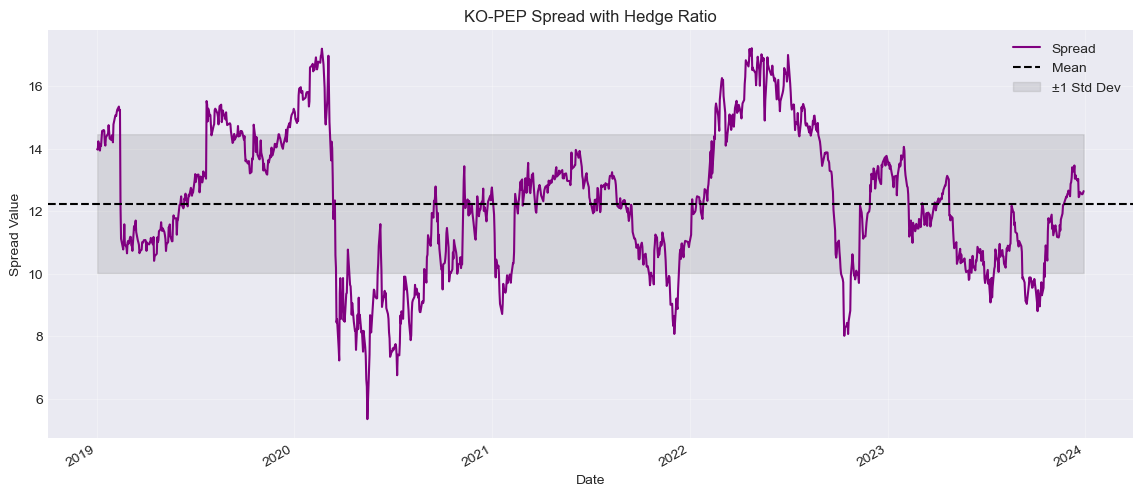

In [53]:
# Calculate the spread using the hedge ratio
spread = strategy.calculate_spread(hedge_ratio=hedge_ratio)

# Plot the spread
plt.figure(figsize=(14, 6))
spread.plot(label='Spread', color='purple')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.fill_between(spread.index, 
                spread.mean() - spread.std(), 
                spread.mean() + spread.std(), 
                alpha=0.2, color='gray', label='±1 Std Dev')
plt.title('KO-PEP Spread with Hedge Ratio')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Calculate Z-Score

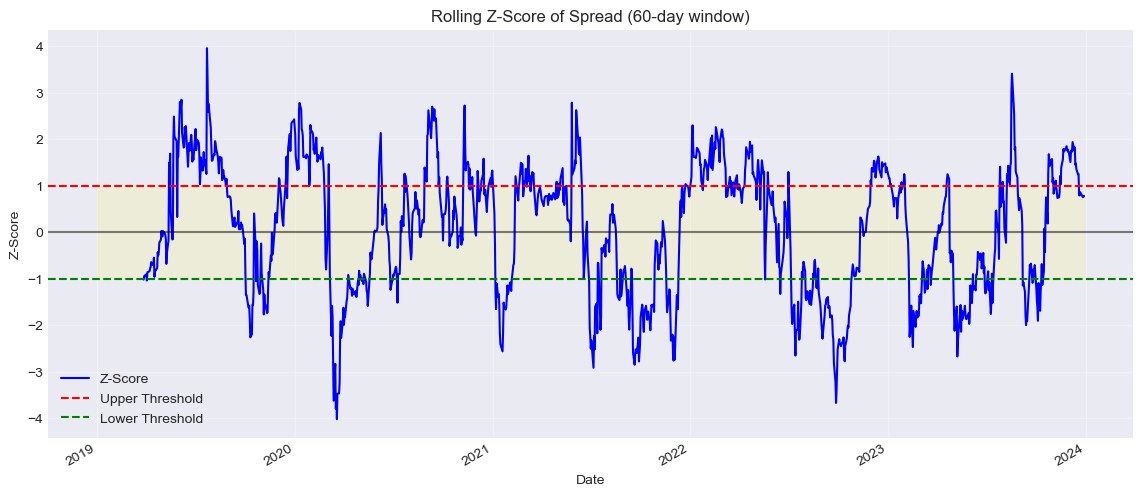

In [56]:
# Calculate rolling z-score with 60-day window
zscore = strategy.calculate_zscore(window=60)

# Plot z-score
plt.figure(figsize=(14, 6))
zscore.plot(label='Z-Score', color='blue')
plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.axhline(1, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-1, color='green', linestyle='--', label='Lower Threshold')
plt.fill_between(zscore.index, -1, 1, alpha=0.1, color='yellow')
plt.title('Rolling Z-Score of Spread (60-day window)')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Generate Trading Signals

In [59]:
# Generate trading signals based on z-score thresholds
signals = strategy.generate_signals(entry_threshold=1.0, exit_threshold=0.0)

# Display signal statistics
print(f"Total number of trades: {int(abs(signals['trades']).sum() / 2)}")
print(f"Long positions: {(signals['position'] == 1).sum()} days")
print(f"Short positions: {(signals['position'] == -1).sum()} days")
print(f"Neutral positions: {(signals['position'] == 0).sum()} days")

Total number of trades: 23
Long positions: 559 days
Short positions: 640 days
Neutral positions: 59 days


## 6. Backtesting

In [62]:
# Run backtest with transaction costs
backtest_results = strategy.backtest_strategy(transaction_cost=0.001)

# Calculate performance metrics
performance = strategy.calculate_performance_metrics(risk_free_rate=0.045)

# Display performance metrics
print("\n=== Performance Metrics ===")
for metric, value in performance.items():
    print(f"{metric:<20}: {value}")


=== Performance Metrics ===
Total Return        : -1.15%
CAGR                : -0.23%
Sharpe Ratio        : -0.26
Sortino Ratio       : -0.31
Max Drawdown        : -23.97%
Win Rate            : 49.79%
Avg Win             : 0.606%
Avg Loss            : -0.594%
Profit Factor       : 1.01
Total Trades        : 23


## 7. Visualize Results

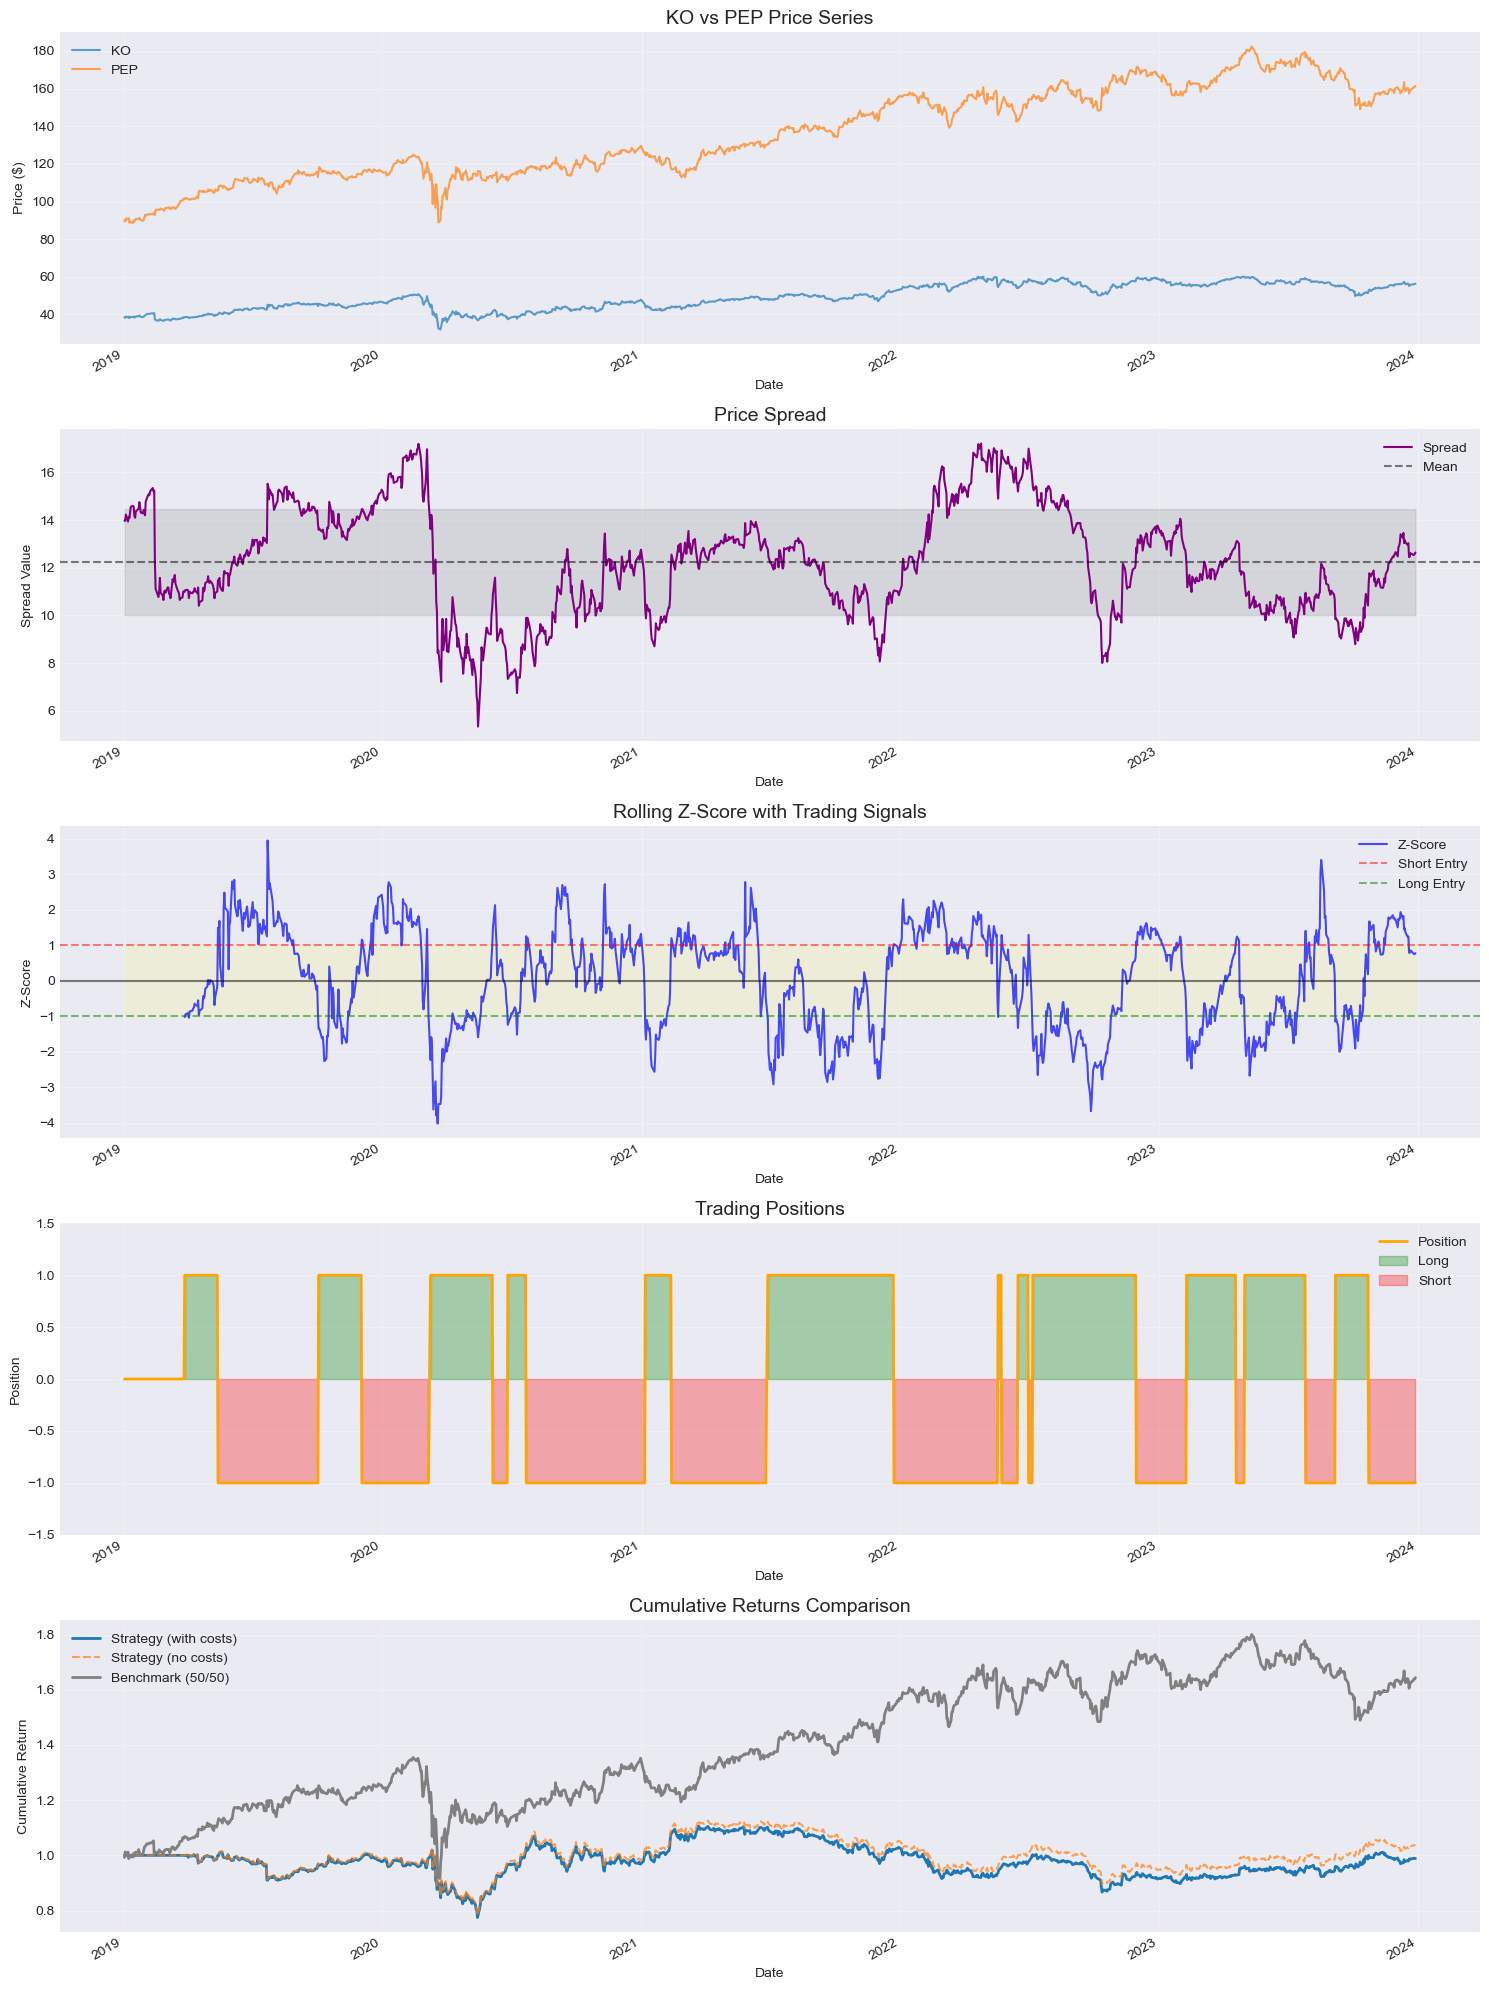

AttributeError: Line2D.set() got an unexpected keyword argument 'fill'

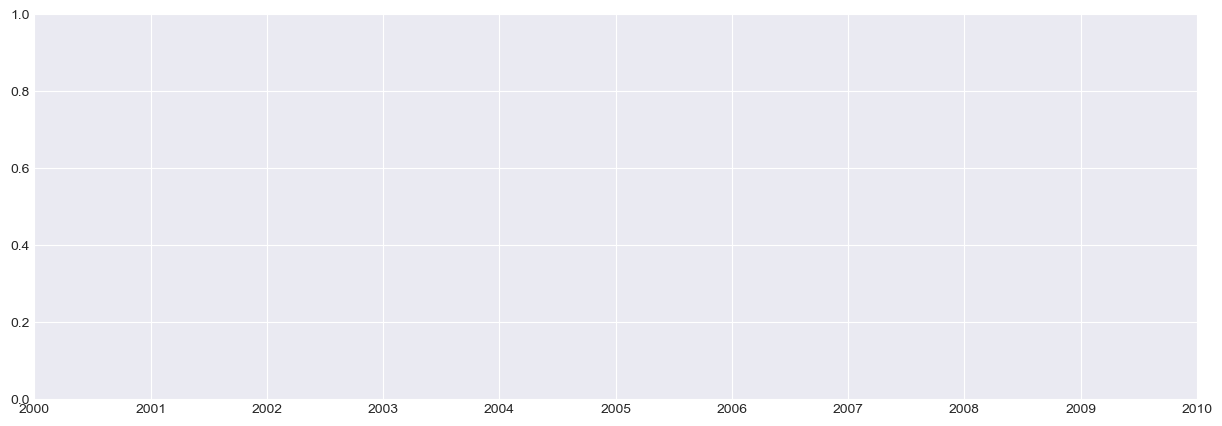

In [65]:
# Generate comprehensive plots
strategy.plot_analysis()

## 8. Parameter Optimization

### 8.1 Grid Search for Optimal Parameters

In [69]:
# Define parameter ranges
windows = [30, 60, 90, 120]
entry_thresholds = [0.5, 1.0, 1.5, 2.0]

# Store results
optimization_results = []

print("Running parameter optimization...")
print("-" * 60)

for window in windows:
    for threshold in entry_thresholds:
        # Create new strategy instance
        test_strategy = PairsTradingStrategy('KO', 'PEP', '2019-01-01', '2024-01-01')
        
        # Run strategy with current parameters
        test_strategy.fetch_data()
        test_strategy.calculate_hedge_ratio()
        test_strategy.calculate_spread()
        test_strategy.calculate_zscore(window=window)
        test_strategy.generate_signals(entry_threshold=threshold)
        test_strategy.backtest_strategy()
        metrics = test_strategy.calculate_performance_metrics()
        
        # Extract key metrics
        sharpe = float(metrics['Sharpe Ratio'])
        total_return = float(metrics['Total Return'].strip('%')) / 100
        max_dd = float(metrics['Max Drawdown'].strip('%')) / 100
        
        optimization_results.append({
            'Window': window,
            'Threshold': threshold,
            'Sharpe Ratio': sharpe,
            'Total Return': total_return,
            'Max Drawdown': max_dd
        })
        
        print(f"Window: {window:3d}, Threshold: {threshold:.1f} => "
              f"Sharpe: {sharpe:6.2f}, Return: {total_return:7.2%}, MaxDD: {max_dd:7.2%}")

# Convert to DataFrame for analysis
opt_df = pd.DataFrame(optimization_results)

Running parameter optimization...
------------------------------------------------------------
Fetching data for KO and PEP...
Data shape: (1258, 10)
Column names: [('Close', 'KO'), ('Close', 'PEP'), ('High', 'KO'), ('High', 'PEP'), ('Low', 'KO'), ('Low', 'PEP'), ('Open', 'KO'), ('Open', 'PEP'), ('Volume', 'KO'), ('Volume', 'PEP')]
Available price types: ['Close', 'High', 'Low', 'Open', 'Volume']
Successfully loaded data with shape: (1258, 2)

Hedge Ratio (OLS): 0.2710
Intercept: 12.2395

Testing spread stationarity:

ADF Test for Spread:
ADF Statistic: -1.8670
p-value: 0.3477
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
=> Spread is non-stationary (fail to reject H0)
Window:  30, Threshold: 0.5 => Sharpe:  -0.12, Return:   8.06%, MaxDD: -22.35%
Fetching data for KO and PEP...
Data shape: (1258, 10)
Column names: [('Close', 'KO'), ('Close', 'PEP'), ('High', 'KO'), ('High', 'PEP'), ('Low', 'KO'), ('Low', 'PEP'), ('Open', 'KO'), ('Open', 'PEP'), ('Volume', 'KO'), ('Volume', 'PEP

### 8.2 Visualize Optimization Results

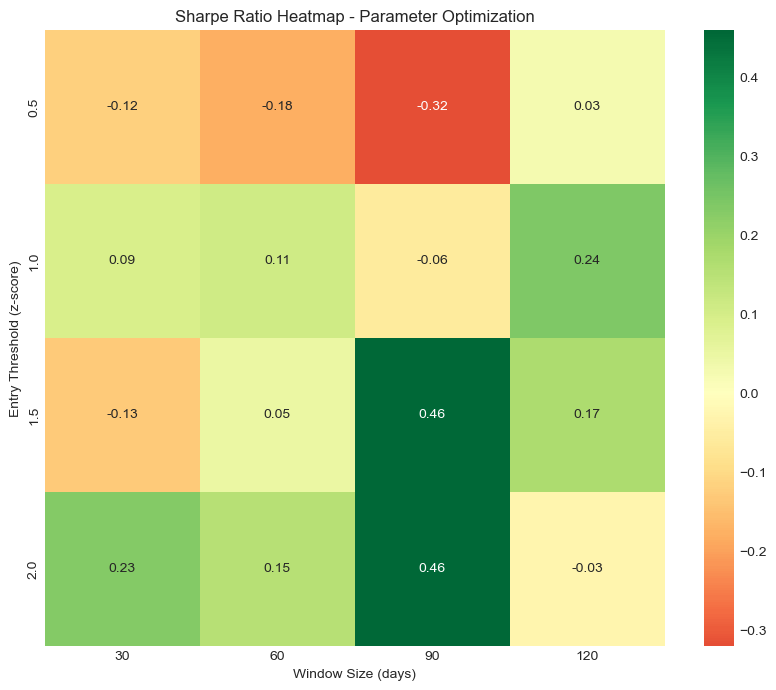


=== Best Parameters ===
Window: 90.0 days
Entry Threshold: 1.5
Sharpe Ratio: 0.46
Total Return: 65.49%
Max Drawdown: -13.80%


In [74]:
# Create heatmap of Sharpe ratios
pivot_sharpe = opt_df.pivot(index='Threshold', columns='Window', values='Sharpe Ratio')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title('Sharpe Ratio Heatmap - Parameter Optimization')
plt.xlabel('Window Size (days)')
plt.ylabel('Entry Threshold (z-score)')
plt.show()

# Find best parameters
best_params = opt_df.loc[opt_df['Sharpe Ratio'].idxmax()]
print("\n=== Best Parameters ===")
print(f"Window: {best_params['Window']} days")
print(f"Entry Threshold: {best_params['Threshold']}")
print(f"Sharpe Ratio: {best_params['Sharpe Ratio']:.2f}")
print(f"Total Return: {best_params['Total Return']:.2%}")
print(f"Max Drawdown: {best_params['Max Drawdown']:.2%}")

## 9. Run Strategy with Optimal Parameters


=== Running Strategy with Optimal Parameters ===
=== Pairs Trading Strategy: KO vs PEP ===

Fetching data for KO and PEP...
Data shape: (1258, 10)
Column names: [('Close', 'KO'), ('Close', 'PEP'), ('High', 'KO'), ('High', 'PEP'), ('Low', 'KO'), ('Low', 'PEP'), ('Open', 'KO'), ('Open', 'PEP'), ('Volume', 'KO'), ('Volume', 'PEP')]
Available price types: ['Close', 'High', 'Low', 'Open', 'Volume']
Successfully loaded data with shape: (1258, 2)

Data shape: (1258, 2)
Date range: 2019-01-02 00:00:00 to 2023-12-29 00:00:00

ADF Test for KO:
ADF Statistic: -1.7137
p-value: 0.4241
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
=> KO is non-stationary (fail to reject H0)

ADF Test for PEP:
ADF Statistic: -1.7620
p-value: 0.3995
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
=> PEP is non-stationary (fail to reject H0)

=== Cointegration Test Results ===
Test Statistic: -3.1930
p-value: 0.0711
Critical Values: 1%: -3.905, 5%: -3.341, 10%: -3.048
=> Series are NOT cointegrated (caut

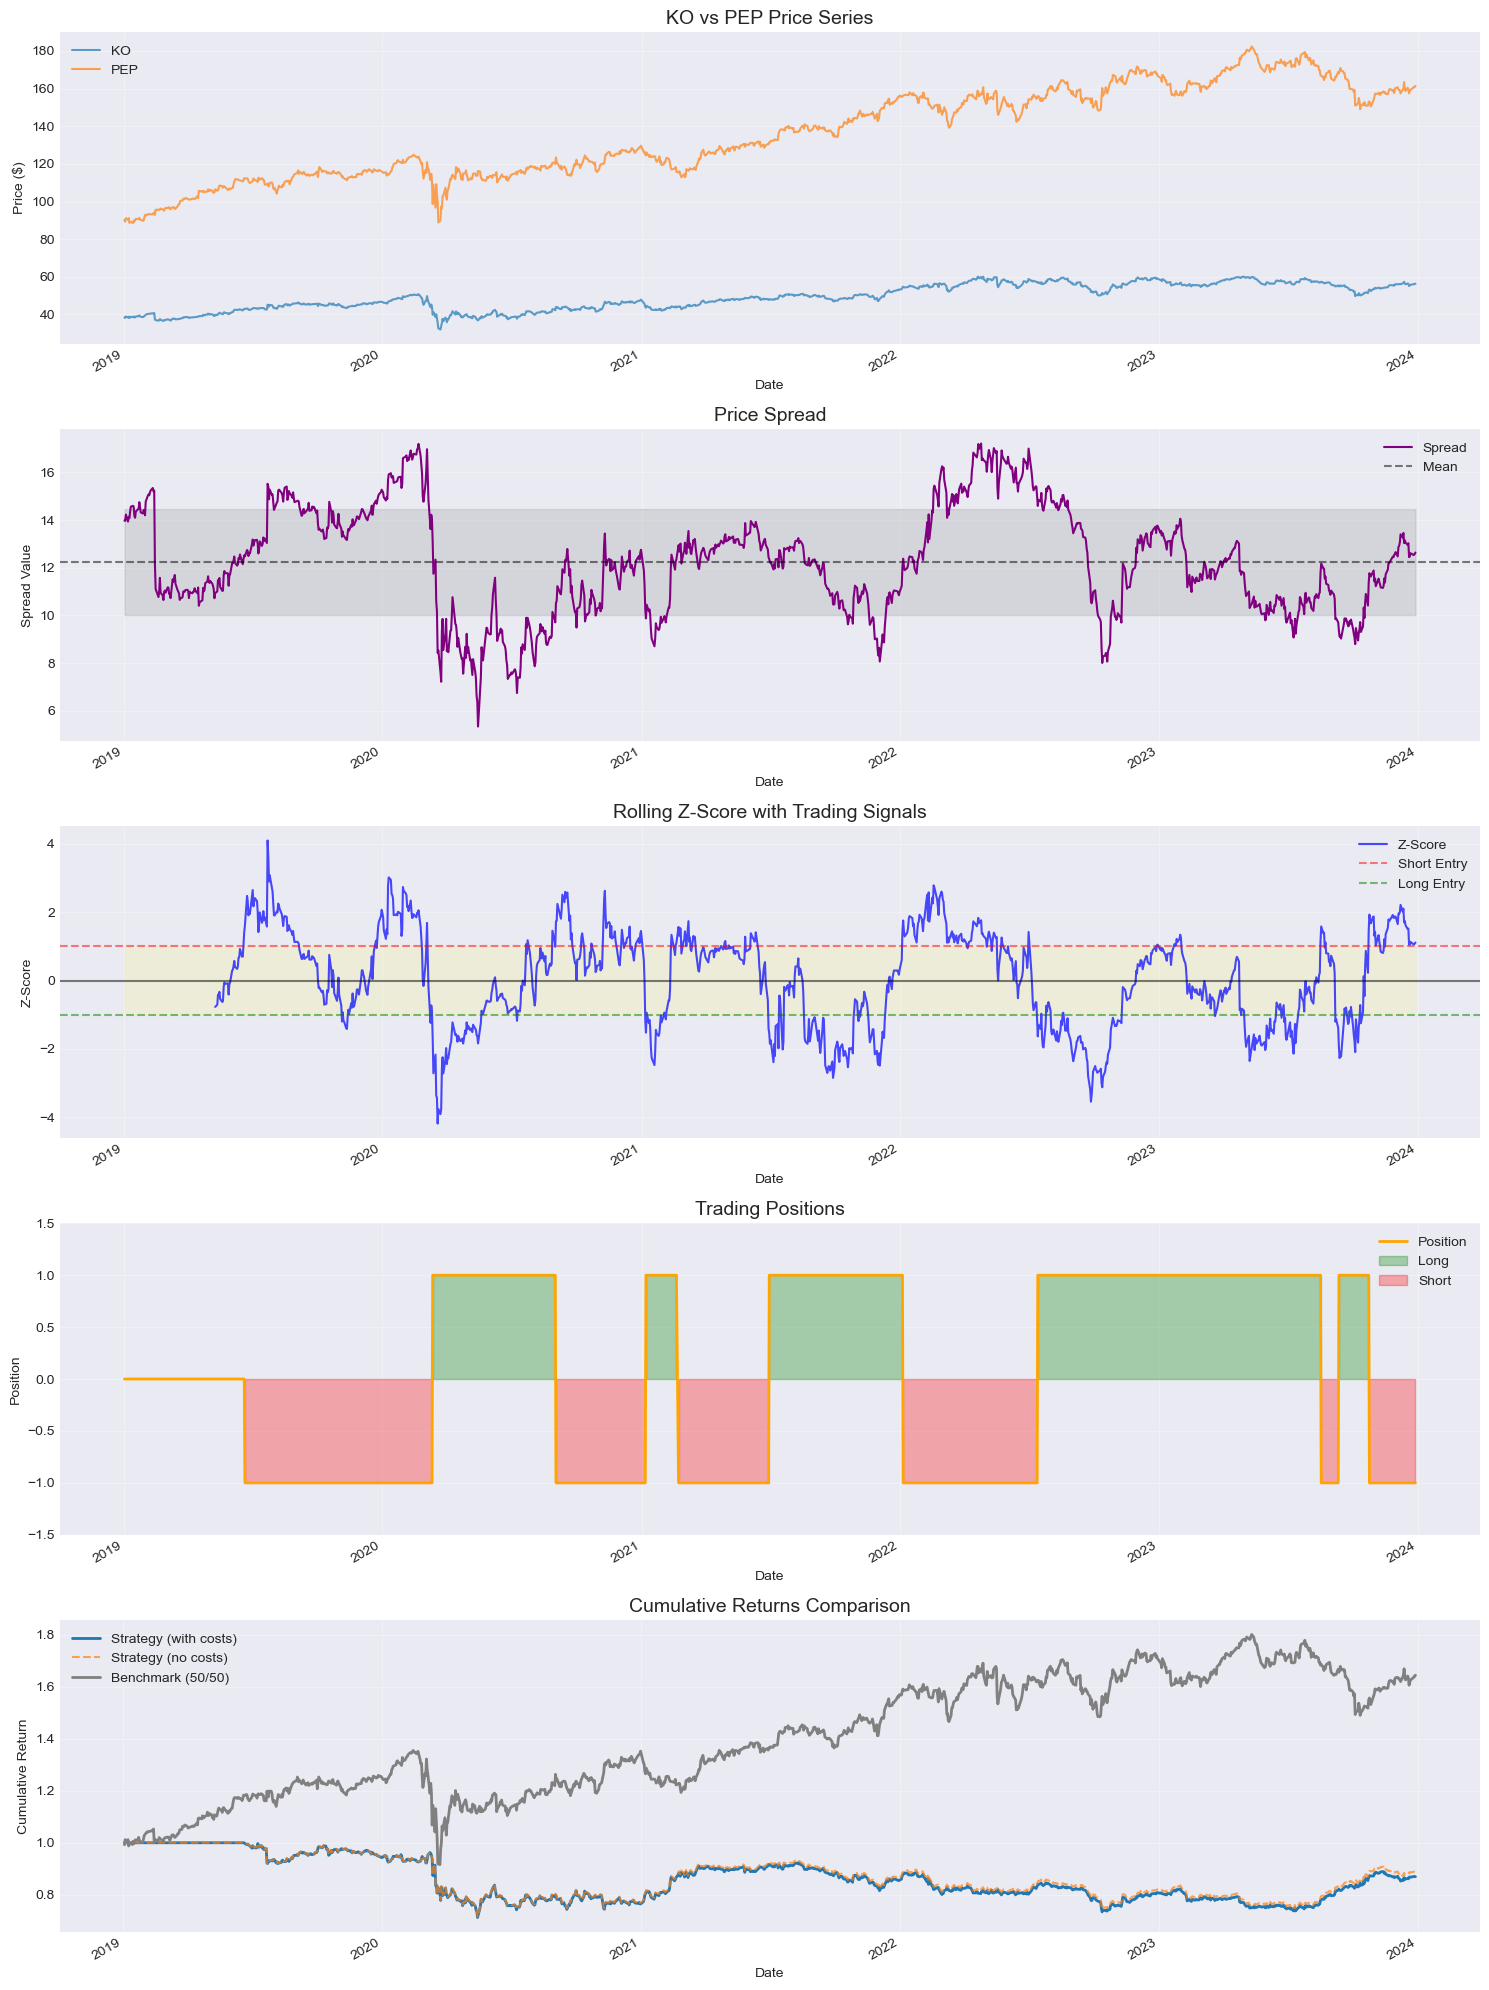

In [83]:
# Run strategy with best parameters
print("\n=== Running Strategy with Optimal Parameters ===")
optimal_strategy = PairsTradingStrategy('KO', 'PEP', '2019-01-01', '2024-01-01')

# Use best parameters
best_window = int(best_params['Window'])
best_threshold = best_params['Threshold']

# Run full analysis
optimal_results = optimal_strategy.run_full_analysis(
    window=best_window,
    entry_threshold=best_threshold,
    exit_threshold=0.0
)

## 10. Additional Analysis

### 10.1 Monthly Returns Analysis

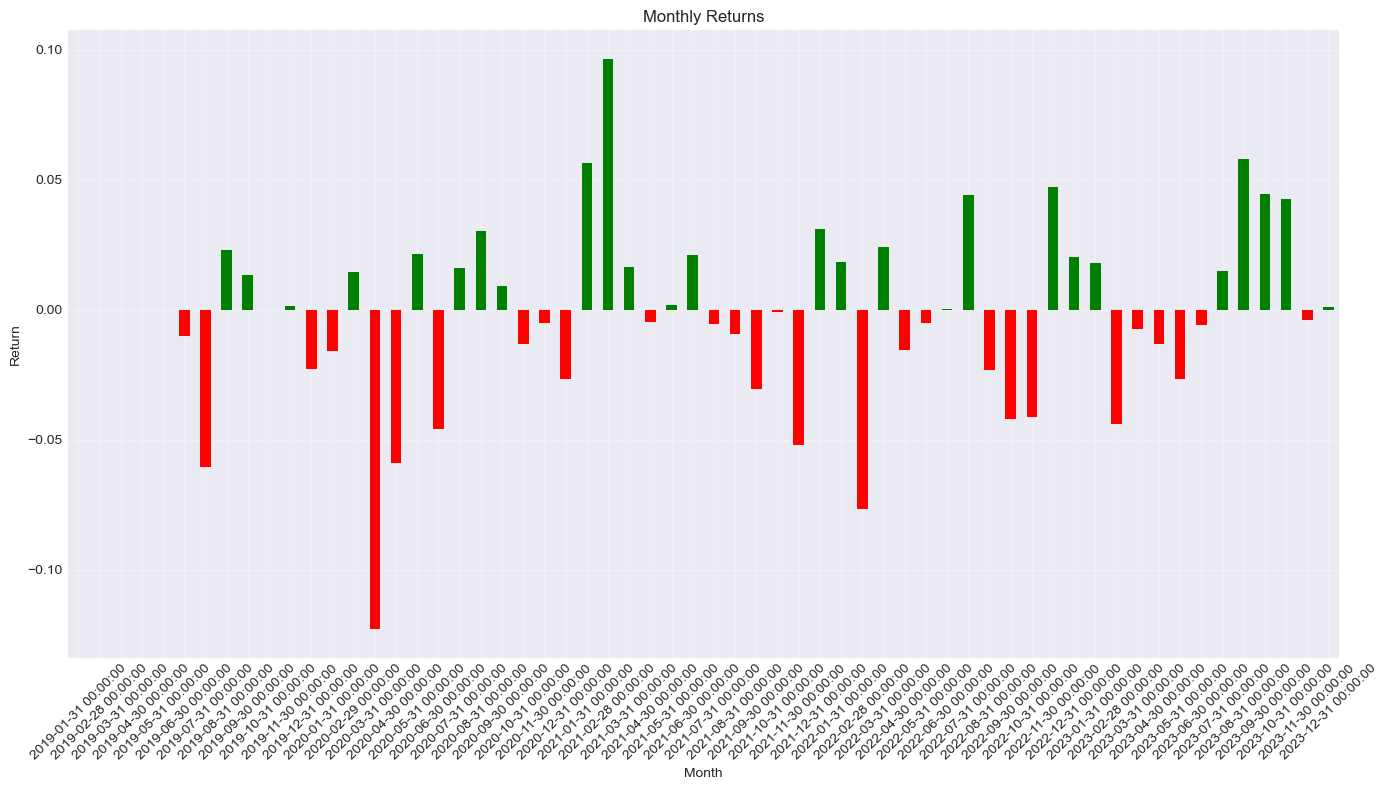

Average Monthly Return: -0.17%
Monthly Volatility: 3.51%
Best Month: 9.66%
Worst Month: -12.29%


In [85]:
# Calculate monthly returns
monthly_returns = optimal_strategy.signals['strategy_returns_tc'].resample('M').apply(
    lambda x: (1 + x).prod() - 1
)

# Plot monthly returns
plt.figure(figsize=(14, 8))
monthly_returns.plot(kind='bar', color=['green' if x > 0 else 'red' for x in monthly_returns])
plt.title('Monthly Returns')
plt.xlabel('Month')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Monthly statistics
print(f"Average Monthly Return: {monthly_returns.mean():.2%}")
print(f"Monthly Volatility: {monthly_returns.std():.2%}")
print(f"Best Month: {monthly_returns.max():.2%}")
print(f"Worst Month: {monthly_returns.min():.2%}")

### 10.2 Rolling Performance Metrics

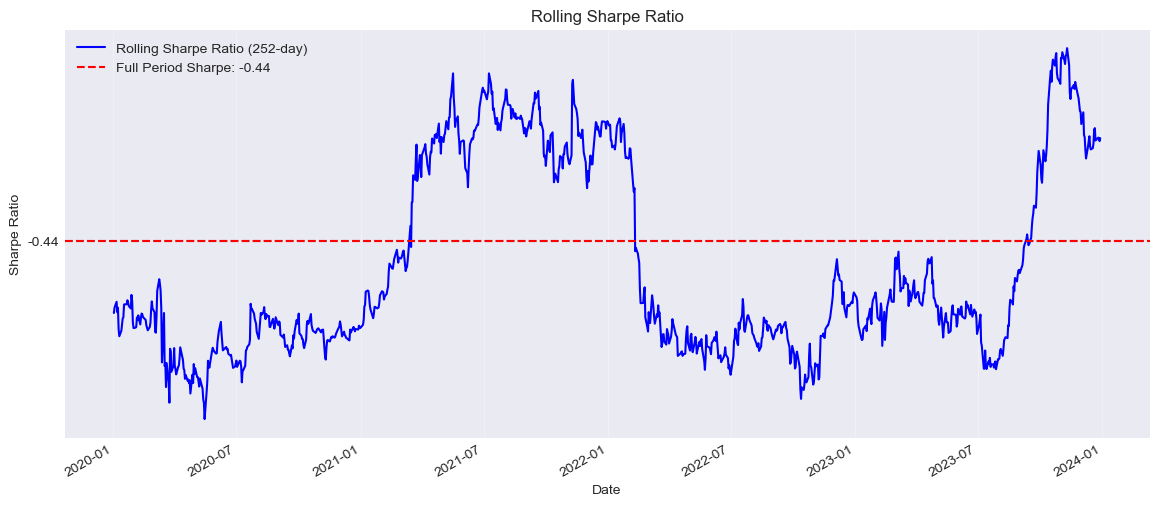

In [87]:
# Calculate rolling 252-day Sharpe ratio
returns = optimal_strategy.signals['strategy_returns_tc']
rolling_sharpe = returns.rolling(252).apply(
    lambda x: np.sqrt(252) * x.mean() / x.std() if x.std() > 0 else 0
)

plt.figure(figsize=(14, 6))
rolling_sharpe.plot(label='Rolling Sharpe Ratio (252-day)', color='blue')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axhline(optimal_strategy.results['Sharpe Ratio'], 
            color='red', linestyle='--', 
            label=f"Full Period Sharpe: {optimal_strategy.results['Sharpe Ratio']}")
plt.title('Rolling Sharpe Ratio')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()